In [5]:
import kagglehub
import random
import pickle
from datetime import datetime
import time

import torch
from torchmetrics.classification import MulticlassF1Score
import torchvision.transforms as transforms
from torchvision import datasets, models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
# from sklearn.metrics import f1_score, confusion_matrix

import numpy as np
import seaborn as sns
import mplcyberpunk
import matplotlib.pyplot as plt


import mlflow
import mlflow.pytorch
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, TensorSpec

torch.manual_seed(42)
plt.style.use('cyberpunk')

In [6]:
# Download latest version
path = kagglehub.dataset_download("fanconic/skin-cancer-malignant-vs-benign")

print("Path to dataset files:", path)

Path to dataset files: /home/pampa89d/.cache/kagglehub/datasets/fanconic/skin-cancer-malignant-vs-benign/versions/4


In [7]:
config = {
    'batch_size': 64,
    'learning_rate': 0.001,
    'epochs': 10,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'data_dir': 'data/',
    'log_dir': 'runs/experiment'
}

# Устанавливаем глобальные параметры
# !!! Не используйте этот флаг, если размеры входных данных постоянно меняются
torch.backends.cudnn.benchmark = True  # Оптимизация для GPU, заставляет cuDNN использовать алгоритмы, которые быстрее на данной архитектуре
torch.backends.cudnn.enabled = True  # Включаем cuDNN
torch.backends.cudnn.allow_tf32 = True  # Использование TensorFloat-32 для ускорения вычислений на GPU

# Устанавливаем флаг для воспроизводимости, отключаем при обычном обучении т.к. это может замедлить обучение
torch.backends.cudnn.enabled = True  # Включаем
torch.backends.cudnn.deterministic = True  # Детерминированность для воспроизводимости
DEVICE = config['device']
BATCH_SIZE = config['batch_size']

In [8]:
# Трансформации для ОБУЧАЮЩЕЙ выборки (с аугментациями: поворот, масштабирование, изменение яркости, добавление шума)
# Аугментации помогают модели лучше обобщать и предотвращают переобучение
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),        # Изменяем размер всех изображений до 224x224
    transforms.RandomHorizontalFlip(),    # Случайно отражаем изображение по горизонтали
    transforms.RandomRotation(15),        # Случайно вращаем изображение на 15 градусов
    transforms.ColorJitter(brightness=0.2, contrast=0.2,
                           saturation=0.2, hue=0.1),  # Случайное изменение цвета
    transforms.ToTensor(),                 # Преобразование изображения в тензор PyTorch
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])   # Нормализация (средние и ст.отклонения для ImageNet)
])

# Трансформации для ВАЛИДАЦИОННОЙ выборки (без аугментаций)
valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [9]:
# --- Шаг 2: Создание датасетов с применением трансформаций ---
# Замените 'path/to/your/...' на реальные пути к вашим данным
train_data_path = '~/.cache/kagglehub/datasets/fanconic/skin-cancer-malignant-vs-benign/versions/4/data/train'
valid_data_path = '~/.cache/kagglehub/datasets/fanconic/skin-cancer-malignant-vs-benign/versions/4/data/test'

train_dataset = datasets.ImageFolder(train_data_path, transform=train_transform)
valid_dataset = datasets.ImageFolder(valid_data_path, transform=valid_transform)

In [10]:
# --- Шаг 3: Создание DataLoader'ов ---
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=8)          # shuffle=True ОБЯЗАТЕЛЕН для обучения, чтобы перемешивать данные

valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=8)         # shuffle=False для валидации, так как порядок не важен

In [11]:
print(f"DataLoader для обучения создан. Количество батчей: {len(train_loader)}")
print(f"DataLoader для валидации создан. Количество батчей: {len(valid_loader)}")

DataLoader для обучения создан. Количество батчей: 42
DataLoader для валидации создан. Количество батчей: 11


In [12]:
# количество элементов в датасете
images, labeles = next(iter(train_loader))
print(images.shape)
print('Размерность классов в 1 батче', labeles.unique().shape)

# Количетсуво уникальных классов в датасете.
NUM_CLASSES = len(train_dataset.classes)

torch.Size([64, 3, 224, 224])
Размерность классов в 1 батче torch.Size([2])


In [13]:
# --- Шаг 1: Создание предобученной модели ---
# Используем современный подход с параметром 'weights' (рекомендуется)
weight = models.ConvNeXt_Tiny_Weights.DEFAULT   # .DEFAULT всегда загружает лучшие доступные веса
model = models.convnext_tiny(weights=weight)

In [14]:
# --- Шаг 2: Адаптация модели для вашей задачи (Трансферное обучение) ---
# "Замораживаем" все слои, кроме последнего, чтобы не изменять уже обученные веса
# Это необязательный шаг, но часто используется для более быстрой и стабильной дообучения
for param in model.parameters():
    param.requires_grad = False

In [15]:
# .named_children() - то же самое, но с именами слоев
layers = []
for name, child in model.named_children():
    layers.append(f"Имя слоя: {name}. Параметры слоя: {child}")

# последний слой
layers[-1]

'Имя слоя: classifier. Параметры слоя: Sequential(\n  (0): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)\n  (1): Flatten(start_dim=1, end_dim=-1)\n  (2): Linear(in_features=768, out_features=1000, bias=True)\n)'

In [16]:
# Заменяем последний слой на новый, с нужным количеством выходов
num_ftrs = model.classifier[2].in_features
model.classifier[2] = nn.Linear(num_ftrs, 2)

In [17]:
# --- Шаг 3: Перемещение модели на нужное устройство (GPU или CPU) ---
model.to(DEVICE)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [19]:
# @title
def fit(
        model: torch.nn.Module,
        n_epochs: int,
        optimizer: torch.optim.Optimizer,
        train_loader: DataLoader,
        valid_loader: DataLoader,
        criterion: torch.nn.Module,
        use_mlflow = True,  # [MLflow] Флажок, чтобы включать/выключать логирование
        history=None
        ) -> tuple[list, ...]:

    history = history or {
        'train_accs': [],
        'train_losses': [],
        'valid_accs': [],
        'valid_losses': [],
        'train_f1_scores': [],
        'valid_f1_scores': [],
        'training_time' : []
    }

    train_loss = []
    valid_loss = []
    train_acc = []
    valid_acc = []
    train_f1_score = []
    valid_f1_score = []

    # average='macro' - стратегия усреднения (можно 'weighted' или 'micro').
    f1_scorer = MulticlassF1Score(num_classes=NUM_CLASSES, average='macro').to(DEVICE)
    
    start_time = datetime.now()

    for epoch in range(1, n_epochs+1):
        model.train()
        # Не забудьте сбросить состояние метрики перед новой эпохой
        f1_scorer.reset()
        batch_losses = []
        batch_accs = []

        for images, labels in train_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            y_pred = model(images)
            # вычисление потерь на батчах
            loss = criterion(y_pred, labels)
            # Обновляем состояние метрики на каждом батче
            f1_scorer.update(y_pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())
            batch_accs.append((y_pred.argmax(dim=1) == labels).float().mean().item())

        train_loss = np.mean(batch_losses)
        train_acc  = np.mean(batch_accs)
        # --- В конце эпохи ---
        # Вычисляем итоговый F1-score по всем батчам, которые "увидела" метрика
        train_f1_score = f1_scorer.compute()
        history['train_losses'].append(train_loss)
        history['train_accs'].append(train_acc)
        history['train_f1_scores'].append(train_f1_score)

        batch_losses = []
        batch_accs = []

        model.eval()
        with torch.no_grad():
            for images, labels in valid_loader:
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)

                y_pred = model(images)
                # вычисление потерь на батчах
                loss = criterion(y_pred, labels)
                # Обновляем состояние метрики на каждом батче
                f1_scorer.update(y_pred, labels)

                batch_losses.append(loss.item())
                batch_accs.append((y_pred.argmax(dim=1) == labels).float().mean().item())

            valid_loss = np.mean(batch_losses)
            valid_acc  = np.mean(batch_accs)
            # --- В конце эпохи ---
            # Вычисляем итоговый F1-score по всем батчам, которые "увидела" метрика
            valid_f1_score = f1_scorer.compute()
            history['valid_losses'].append(valid_loss)
            history['valid_accs'].append(valid_acc)
            history['valid_f1_scores'].append(valid_f1_score)

            # [MLflow] Логируем метрики
            if use_mlflow:
                # epoch – номер шага (можно указывать step=epoch)
                mlflow.log_metric("train_loss", train_loss, step=epoch)
                mlflow.log_metric("valid_loss", valid_loss, step=epoch)
                mlflow.log_metric("train_acc",  train_acc,  step=epoch)
                mlflow.log_metric("valid_acc",  valid_acc,  step=epoch)
                mlflow.log_metric("train_f1_scores",  train_f1_score,  step=epoch)
                mlflow.log_metric("valid_f1_scores",  valid_f1_score,  step=epoch)

            print(
                f"Epoch {epoch}/{n_epochs} | "
                f"Train Loss: {train_loss:.4f}, Val Loss: {valid_loss:.4f} | "
                f"Train Acc: {train_acc:.4f}, Val Acc: {valid_acc:.4f} | "
                f"Train f1_score: {train_f1_score:.4f}, Val f1_score: {valid_f1_score:.4f}"
            )

    # Функция форматирования из Способа 2
    def format_time(seconds):
        if seconds < 3600:
            mins = int(seconds // 60)
            secs = int(seconds % 60)
            return f"{mins:02d}:{secs:02d}"
        else:
            hours = int(seconds // 3600)
            mins = int((seconds % 3600) // 60)
            secs = int(seconds % 60)
            return f"{hours:02d}:{mins:02d}:{secs:02d}"

    finish_time = (datetime.now() - start_time).total_seconds()
    history['training_time'].append(format_time(finish_time))

    print(f"Traininig duration: {format_time(finish_time)}")

    return history

In [24]:
def mlflow_run(n_epochs=config['epochs'], use_mlflow=True, model=model, 
                optimizer=torch.optim.Optimizer, criterion=torch.nn.Module,
                train_loader=train_loader, valid_loader=valid_loader,
                model_name='model'):
    # команда bash для открытия mlflow < mlflow ui >

    # [MLflow] Запуск эксперимента через контекстный менеджер 
    # Здесь можно выбрать или задать название эксперимента
    # (если такового нет, MLflow создаст новый)
    mlflow_experiment_name = "MNIST-BaseCNN-Experiment"

    # Завершаем любой активный запуск, если он есть
    mlflow.end_run()

    if use_mlflow:
        mlflow.set_experiment(mlflow_experiment_name)  # установить (или создать) эксперимент
        with mlflow.start_run(run_name="MNIST_CNN_bs_1024_lr_0.002"):
            # Логируем гиперпараметры из config
            mlflow.log_param("batch_size",      config['batch_size'])
            mlflow.log_param("learning_rate",   config['learning_rate'])
            mlflow.log_param("epochs",          config['epochs'])
            mlflow.log_param("device",          config['device'])

            # Запускаем обучение
            model_metrics = fit(model=model, n_epochs=n_epochs, optimizer=optimizer, criterion=criterion,
                        train_loader=train_loader, valid_loader=valid_loader)

            input_tensor, _ = next(iter(train_loader))
            input_tensor = input_tensor.to(config['device'], dtype=torch.float32)

            # 2. Делаем тестовый прогон, чтобы получить пример выхода
            #    torch.no_grad() важен, чтобы не считать градиенты и сэкономить память
            with torch.no_grad():
                output_tensor = model(input_tensor)

            # 3. Конвертируем оба тензора в NumPy массивы (на CPU)
            input_numpy = input_tensor.cpu().numpy()
            output_numpy = output_tensor.cpu().numpy()

            # 4. Описываем схему для входа и выхода, используя их форму и тип данных
            input_schema = Schema([
                TensorSpec(input_numpy.dtype, input_numpy.shape, name="input")
            ])
            output_schema = Schema([
                TensorSpec(output_numpy.dtype, output_numpy.shape, name="output")
            ])

            # 5. Собираем полную сигнатуру модели из схем входа и выхода
            manual_signature = ModelSignature(inputs=input_schema, outputs=output_schema)

            # 6. Логируем модель с явно указанной сигнатурой и примером в формате NumPy
            mlflow.pytorch.log_model(
                pytorch_model=model,
                name=model_name,
                signature=manual_signature,       # <-- Передаем созданную вручную сигнатуру
            )
        # После выхода из `with` Run автоматически завершается
    else:
        # Если не используем MLflow
        model_metrics = fit(model, n_epochs, optimizer, criterion,
                train_loader, valid_loader)
    
    return model_metrics

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
model_metrics_1 = mlflow_run(n_epochs=5, optimizer=optimizer, criterion=criterion)

Epoch 1/5 | Train Loss: 0.3058, Val Loss: 0.3269 | Train Acc: 0.8654, Val Acc: 0.8491 | Train f1_score: 0.8633, Val f1_score: 0.8621
Epoch 2/5 | Train Loss: 0.3034, Val Loss: 0.3238 | Train Acc: 0.8620, Val Acc: 0.8509 | Train f1_score: 0.8613, Val f1_score: 0.8602


In [ ]:
# Укажите путь и имя файла
PATH = "resnet50_weights_.pth"

# Сохраняем state_dict
torch.save(model.state_dict(), PATH)

print(f"Веса модели сохранены в файл: {PATH}")

Веса модели сохранены в файл: resnet50_weights_.pth


In [ ]:
def predict(model: torch.nn.Module, data_loader: DataLoader, device: torch.device) -> tuple[list, list]:
    """
    Функция для получения предсказаний модели на заданных данных.

    Args:
        model: Обученная модель.
        data_loader: DataLoader с данными, для которых нужно сделать предсказания.
        device: Устройство (CPU или CUDA), на котором выполняются вычисления.

    Returns:
        Кортеж из двух списков: (предсказанные метки, истинные метки).
    """
    model.eval()  # Переводим модель в режим оценки (evaluation)
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Отключаем вычисление градиентов
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Получаем предсказания модели (логиты)
            outputs = model(images)

            # Находим класс с максимальной вероятностью
            preds = torch.argmax(outputs, dim=1)

            # Собираем предсказания и метки с каждого батча
            # .cpu() - переносим на CPU, .numpy() - в numpy, .tolist() - в обычный список python
            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    return all_preds, all_labels

In [ ]:
model_predict = predict(model=model, data_loader=valid_loader, device=DEVICE)

In [ ]:
# --- 1. Вспомогательные данные и функции ---

# Создадим список с названиями классов для наглядности
# В реальной задаче замените их на свои названия
class_names = [f"Класс {i}" for i in valid_dataset.classes]

def unnormalize(tensor, mean, std):
    """
    Выполняет обратное преобразование нормализации для вывода изображения,
    т.к. в тензоре данные хранятся в диапазоне [-2, 2], они преобразуются в диапазон [0, 1]
    формула рассчитывается на месте за счет "_" t=t⋅s+m
    """
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def visualize_prediction(model, data_loader, device, class_names):
    """
    Берет случайное изображение из data_loader, делает предсказание
    и выводит изображение с подписью.
    """
    # Переводим модель в режим оценки
    model.eval()

    # Берем один батч из загрузчика данных
    images, labels = next(iter(data_loader))

    # Выбираем случайное изображение из батча
    idx = random.randint(0, len(images) - 1)
    image = images[idx]
    true_label = labels[idx].item()

    # Добавляем batch dimension на позицию 0 оси (1, C, H, W),
    # т.к. ожидается на вход тензор с 4-мя измерениями и отправляем на устройство
    image_tensor = image.unsqueeze(0).to(device)

    # Получаем предсказание
    with torch.no_grad():
        output = model(image_tensor)
        # Находим индекс класса с максимальной вероятностью пример [0.1,  1.5, -0.9]
        # dim=1 — это ось, которая соответствует классам (строкам), т.е. изображениям
        predicted_idx = torch.argmax(output, dim=1).item()

    # --- Подготовка изображения к выводу ---
    # Перемещаем на CPU
    image_for_plot = image.cpu()

    # Стандартные значения для обратной нормализации (если использовались веса ImageNet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image_for_plot = unnormalize(image_for_plot, mean, std)

    # Меняем порядок осей с (C, H, W) на (H, W, C) для matplotlib
    image_for_plot = image_for_plot.permute(1, 2, 0)

    # Обрезаем значения, чтобы они были в валидном диапазоне [0, 1],
    # т.к. имеются погрешности в типе float после преобразований
    image_for_plot = np.clip(image_for_plot, 0, 1)

    # --- Рисуем изображение ---
    plt.figure(figsize=(6, 6))
    plt.imshow(image_for_plot)

    # Формируем заголовок
    title_text = f"Предсказано: '{class_names[predicted_idx]}'\n" \
                 f"На самом деле: '{class_names[true_label]}'"

    # Окрашиваем заголовок в зависимости от правильности ответа
    if predicted_idx == true_label:
        plt.title(title_text, color="green")
    else:
        plt.title(title_text, color="red")

    plt.axis('off') # Прячем оси
    plt.show()


Визуализация случайного примера из тестовой выборки:


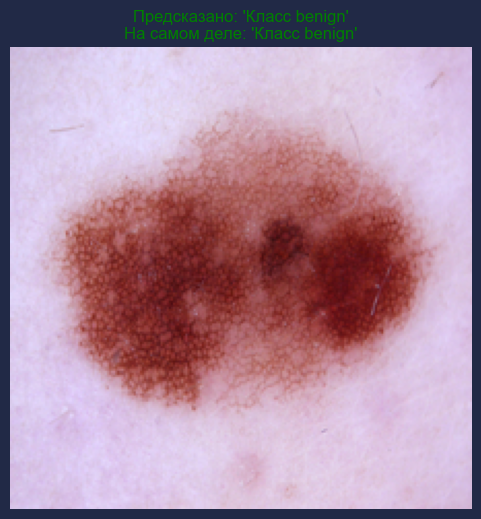

In [ ]:
# --- 2. Запуск визуализации ---
# Вызываем функцию, передав ей нашу обученную модель и валидационный загрузчик
print("\nВизуализация случайного примера из тестовой выборки:")
visualize_prediction(model, valid_loader, DEVICE, class_names)

In [ ]:
# Открываем файл для бинарной записи ('wb' - write binary
with open('../models/fanconic_history.pkl', 'wb') as f:
    pickle.dump(model_metrics_1, f)

In [ ]:
# Открываем файл для бинарной записи ('wb' - write binary
predictions = {'y_pred': model_predict[0], 'y_true': model_predict[1]}
with open('../models/fanconic_predictions.pkl', 'wb') as f:
    pickle.dump(predictions, f)